<h1 style = "color: green"> Esercitazione 4 </h1>

In questa esercitazione studieremo un sistema composto da $N=108$ atomi di argon in un volume costante usando tecniche di dinamica molecolare e applicando le condizioni al contorno periodiche (PBC). L'algoritmo utilizzato è quello di Verlet.  
Misureremo energia potenziale $U$, energia cinetica $K$, energia totale $E$, temperatura $T$ e pressione $P$ nelle tre fasi solida, liquida e gassosa.  

Per l'interazione a coppie tra gli atomi usiamo il potenziale di Lennard-Jones:
$$V(r)=4\epsilon \left( \left( \frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6\right)$$
Introducendo le unità di misura ridotte ($\sigma$ lunghezza, $\epsilon$ energia, $m$ massa), possiamo scrivere $r^*=r/\sigma$, $\epsilon=1$. Il potenziale diventa:
$$V^*(r)=4 \left( \left( \frac{1}{r^*}\right)^{12}-\left(\frac{1}{r^*}\right)^6\right)$$
Nel sistema di unità ridotte, altre grandezze di interesse sono: $T^*=k_BT / \epsilon$, $\rho ^*=\rho \sigma ^3$, $P^*=P\sigma^3 /\epsilon$.  
Per l'argon i parametri sono: $\sigma =0.34$ $nm$, $\epsilon /k_B =120$ $K$, $m=39.948$ $amu$.

L'esercizio 4.1 riguarda solo il codice in C++, al quale aggiungiamo il calcolo della pressione.

<h3 style = "color: blue"> Esercizio 4.2 </h3>

Possiamo ora studiare il sistema in tre condizioni:
- fase solida: $\rho^* = 1.1$, $T^* = 0.8$ (raggio di cut-off: $r_c = 2.2$);
- fase liquida: $\rho^* = 0.8$, $T^* = 1.1$ (raggio di cut-off: $r_c = 2.5$);
- fase gassosa: $\rho^* = 0.05$, $T^* = 1.2$ (raggio di cut-off: $r_c = 5.0$).


Il raggio di cut-off è la distanza oltre la quale trascuriamo le interazioni tra le particelle.  

In ognuna di queste condizioni, simuliamo il sistema per un numero elevato di passi dell'algoritmo e produciamo, con il metodo della media a blocchi, dei grafici dell'andamento della media progressiva, con relativa incertezza, di $U/N$, $K/N$, $E/N$, $T$ e $P$, dove le varie energie sono espresse per particella.

Prima di cominciare la simulazione, sono necessarie alcune considerazioni. Innanzitutto, la scelta della condizione iniziale non può essere casuale: infatti, se due particelle vengono generate molto vicine tra loro, dopo pochi passi avranno un'energia cinetica molto elevata a causa della repulsione reciproca, irrealistica per la temperatura della simulazione, che falserà quindi il valore misurato. Scegliamo allora come condizione iniziale un cristallo con struttura cubica a facce centrate (fcc), che è la configurazione dell'argon solido.  

Non trovandosi a temperatura nulla, il sistema dovrà "sciogliersi", cioè nel caso solido avremo che gli atomi inizieranno a vibrare attorno alla condizione iniziale, mentre negli altri due casi la struttra cristallina si dissolverà.   

In fase solida e liquida, il sistema si trova inizialmente nella struttura fcc che avrebbe se si trovasse nel minimo del potenziale, ma le sue condizioni di temperatura e densità non sono quelle di minimo. Quindi, lasciando libero il sistema, gli atomi si muovono per via della temperatura non nulla e l'energia potenziale $U$ aumenta rispetto a quella del reticolo fcc iniziale. L'algoritmo di Verlet conserva l'energia del sistema $E=U+K$, quindi l'energia cinetica $K$ dovrà diminuire per bilanciare l'aumento di $U$, diminuendo la temperatura ($K=\frac{3}{2}NT$ in unità ridotte).  
In fase gassosa invece, essendo gli atomi molto lontani fra loro, prevarrà la coda attrattiva del potenziale di Lennard-Jones, che tenderà a far aggregare gli atomi, avvicinando quindi il sistema al minimo del potenziale. Quindi lasciando libero di evolvere il sistema, $U$ diminuisce e $K$ aumenta di conseguenza, aumentando la temperatura.  

Per questo motivo, in tutti e tre i casi, dovremo far partire il sistema da una temperatura diversa rispetto a quella a cui vogliamo simularlo, aspettare che si sia stabilizzato, e solo a questo punto cominciare la vera simulazione. Questo processo è detto "termalizzazione" del sistema. Per gli stati solido e liquido dovremo partire da una temperatura più alta ($T^*=1.54 $ e $T^*=1.99 $ rispettivamente), mentre per quello gassoso da una più bassa ($T^*= 0.95$) rispetto a quella elencata sopra. Poi, una volta termalizzato il sistema, possiamo salvare la configurazione finale ottenuta e far ripartire la simulazione da questa, con la temperatura desiderata.

L'evoluzione della temperatura in funzione del passo della simulazione, in fase di termalizzazione, è mostrata nel primo grafico relativo a ogni fase.  

Le conclusioni tratte dall'analisi dei dati delle grandezze di interesse sono riportate alla fine, nella sezione "conclusioni".

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# we define here some generic functions for all three states

# load file containing data and error for block averages
def loadFile2(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    fileLength = len(lines)
    mean = np.empty(fileLength)
    uncertainty = np.empty(fileLength)
    
    for i in range(fileLength):
        values = lines[i].split()
        mean[i], uncertainty[i] = float(values[2]), float(values[3])

    dataFile.close()

    return mean, uncertainty, fileLength



# load file containing temperature data for the thermalization plot
def loadFile1(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    fileLength = len(lines)
    data = np.empty(fileLength)
    
    for i in range(fileLength):
        values = lines[i].split()
        data[i] = float(values[1])

    dataFile.close()

    return data, fileLength



# graph temperature during thermalization phase
def plotTherm(state, targetT):
    data, fileLength = loadFile1("code/" + state + "/therm_temp." + state) # the uncertainty is ignored
    
    x = np.arange(fileLength) + 1
    
    
    # grafico
    fig, ax = plt.subplots(figsize = (12, 6))
    
    ax.axhline(y = targetT, color = "#d82786", label = "valore desiderato: $T^*=$%.1f" % targetT)
    ax.plot(x, data)
    ax.set(title = "Evoluzione della temperatura", xlabel = "passo", ylabel = "T $[\epsilon/k_B]$")
    ax.grid(True)
    ax.legend()
    
    fig.tight_layout()
    plt.show()
    
    return



# graph U/N, K/N, E/N, P, T
def plotData(state, targetT):
    path = "code/" + state + "/"
    
    print("Valori finali in unità ridotte:")
    
    fig, ax = plt.subplots(3, 2, figsize = (12, 12))
    
    
    mean, uncertainty, fileLength = loadFile2(path + "output_ekin.dat")
    x = np.arange(fileLength) + 1

    ax[0, 0].errorbar(x, mean, yerr = uncertainty, color = "black", ecolor = "#1f77b4")
    ax[0, 0].set(title = "Energia cinetica K/N", xlabel = "#blocco", ylabel = "K $[\epsilon]$")
    ax[0, 0].grid(True)
    
    print("<K/N> = %.5f +- %.5f" % (mean[-1], uncertainty[-1]))

    
    mean, uncertainty, fileLength = loadFile2(path + "output_epot.dat")
    x = np.arange(fileLength) + 1

    ax[0, 1].errorbar(x, mean, yerr = uncertainty, color = "black", ecolor = "#1f77b4")
    ax[0, 1].set(title = "Energia potenziale U/N", xlabel = "#blocco", ylabel = "U $[\epsilon]$")
    ax[0, 1].grid(True)
    
    print("<U/N> = %.5f +- %.5f" % (mean[-1], uncertainty[-1]))
    
    
    mean, uncertainty, fileLength = loadFile2(path + "output_etot.dat")
    x = np.arange(fileLength) + 1

    ax[1, 0].errorbar(x, mean, yerr = uncertainty, color = "black", ecolor = "#1f77b4")
    ax[1, 0].set(title = "Energia totale E/N (E=U+K)", xlabel = "#blocco", ylabel = "E $[\epsilon]$")
    ax[1, 0].grid(True)
    
    print("<E/N> = %.5f +- %.5f" % (mean[-1], uncertainty[-1]))
    
    
    ax[1,1].set_axis_off()

    
    mean, uncertainty, fileLength = loadFile2(path + "output_pres.dat")
    x = np.arange(fileLength) + 1

    ax[2, 0].errorbar(x, mean, yerr = uncertainty, color = "black", ecolor = "#1f77b4")
    ax[2, 0].set(title = "Pressione P", xlabel = "#blocco", ylabel = "P $[\epsilon /\sigma ^3]$")
    ax[2, 0].grid(True)
    
    print("<P> = %.5f +- %.5f" % (mean[-1], uncertainty[-1]))

    
    mean, uncertainty, fileLength = loadFile2(path + "output_temp.dat")
    x = np.arange(fileLength) + 1

    ax[2, 1].errorbar(x, mean, yerr = uncertainty, color = "black", ecolor = "#1f77b4")
    ax[2, 1].set(title = "Temperatura T", xlabel = "#blocco", ylabel = "T $[\epsilon/k_B]$")
    ax[2, 1].grid(True)
    ax[2, 1].axhline(y = targetT, color = "#d82786", label = "valore desiderato: $T^*=$%.1f" % targetT)
    ax[2, 1].legend()
    
    print("<T> = %.5f +- %.5f" % (mean[-1], uncertainty[-1]))
    

    fig.tight_layout()
    plt.show()
    
    return

<h4> Stato solido </h4>

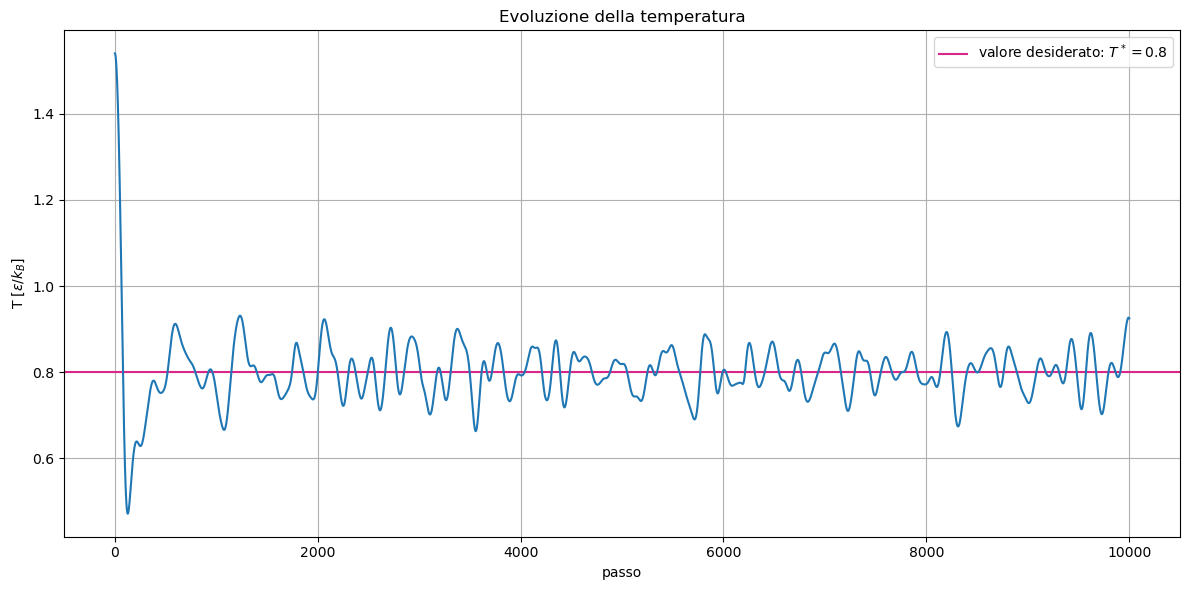

In [17]:
plotTherm("solid", 0.8)

Notiamo come, con la temperatura iniziale scelta ($T^*=1.54$), il valore della temperaura oscilla attorno al valore desiderato. Come vedremo in seguito, la temperatura finale è compatibile con quella desiderata ($T^*=0.8$).  
Il sistema risulta termalizzato già dopo circa $1000$ passi, ma per produrre questo grafico ne abbiamo già simulati $10000$, quindi usiamo i risultati finali ottenuti qui come stato iniziale della simulazione vera e propria.

I risultati della simulazione (medie e incertezze progressive di $K/N$, $U/N$, $E/N$, $P$ e $T$) sono riportati nei grafici seguenti. Questi sono ottenuti simulando $50$ blocchi da $2000$ passi, poiché, come si può verificare dal grafico precedente per quanto riguarda la temperatura, questo valore è sufficiente per avere molte oscillazioni delle quantità d'interesse in un blocco, in modo da rendere la media il più accurata possibile.

Valori finali in unità ridotte:
<K/N> = 1.19966 +- 0.00061
<U/N> = -6.66222 +- 0.00062
<E/N> = -5.46256 +- 0.00008
<P> = 9.60373 +- 0.00307
<T> = 0.79977 +- 0.00041


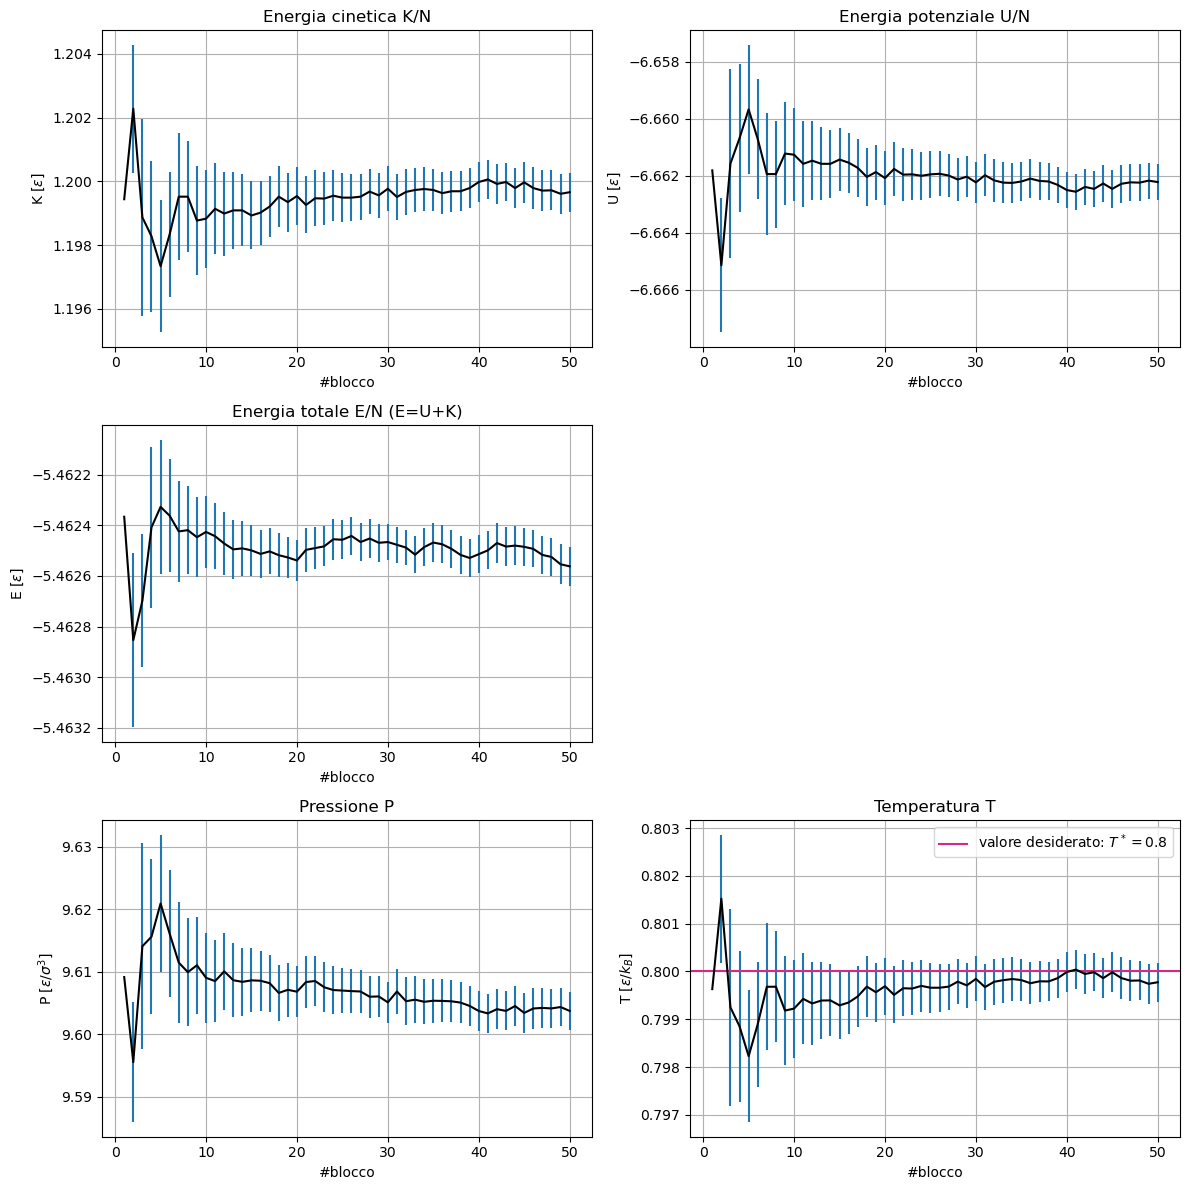

In [18]:
plotData("solid", 0.8)

<h4> Stato liquido </h4>

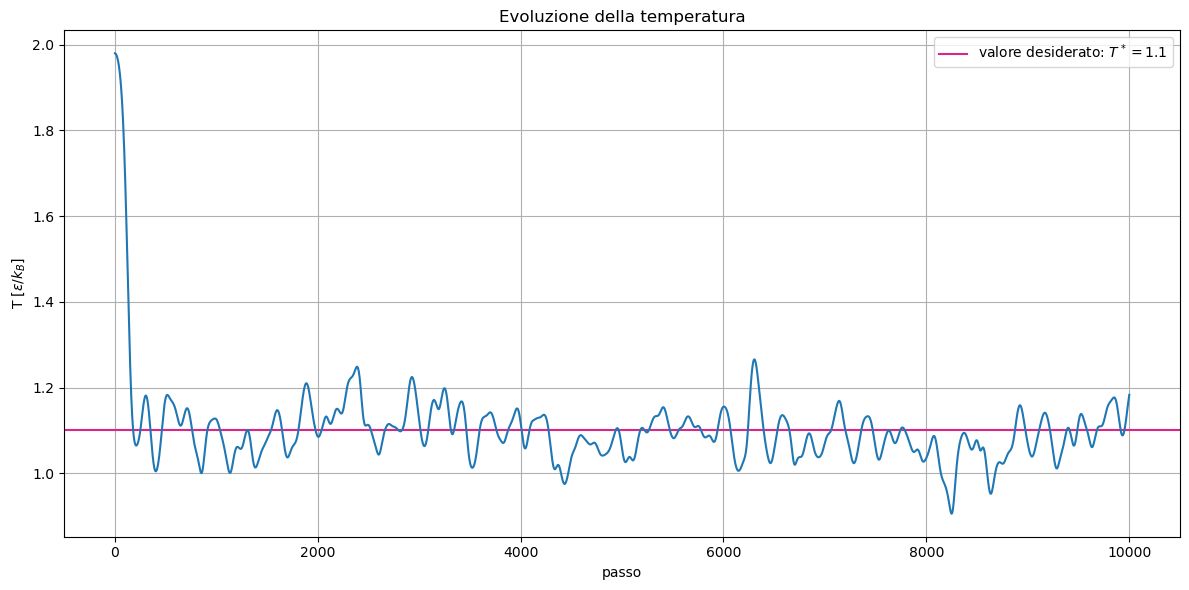

In [19]:
plotTherm("liquid", 1.1)

Anche in questo caso il sistema è termalizzato rapidamente: già dopo meno di $1000$ passi inizia a oscillare attorno al valore desiderato ($T^*=1.1$). La temperatura di partenza è $T^*=1.99$.  
Procediamo quindi come nel caso precedente, ma con blocchi da $4000$ passi poiché le oscillazioni hanno un periodo leggermente più lungo e il moto delle particelle di un liquido è molto meno ordinato che in un solido.  

I risultati della simulazione sono mostrati nei grafici seguenti, analogamente al caso precedente.

Valori finali in unità ridotte:
<K/N> = 1.64620 +- 0.00222
<U/N> = -5.02567 +- 0.00227
<E/N> = -3.37947 +- 0.00012
<P> = 2.13421 +- 0.01121
<T> = 1.09746 +- 0.00148


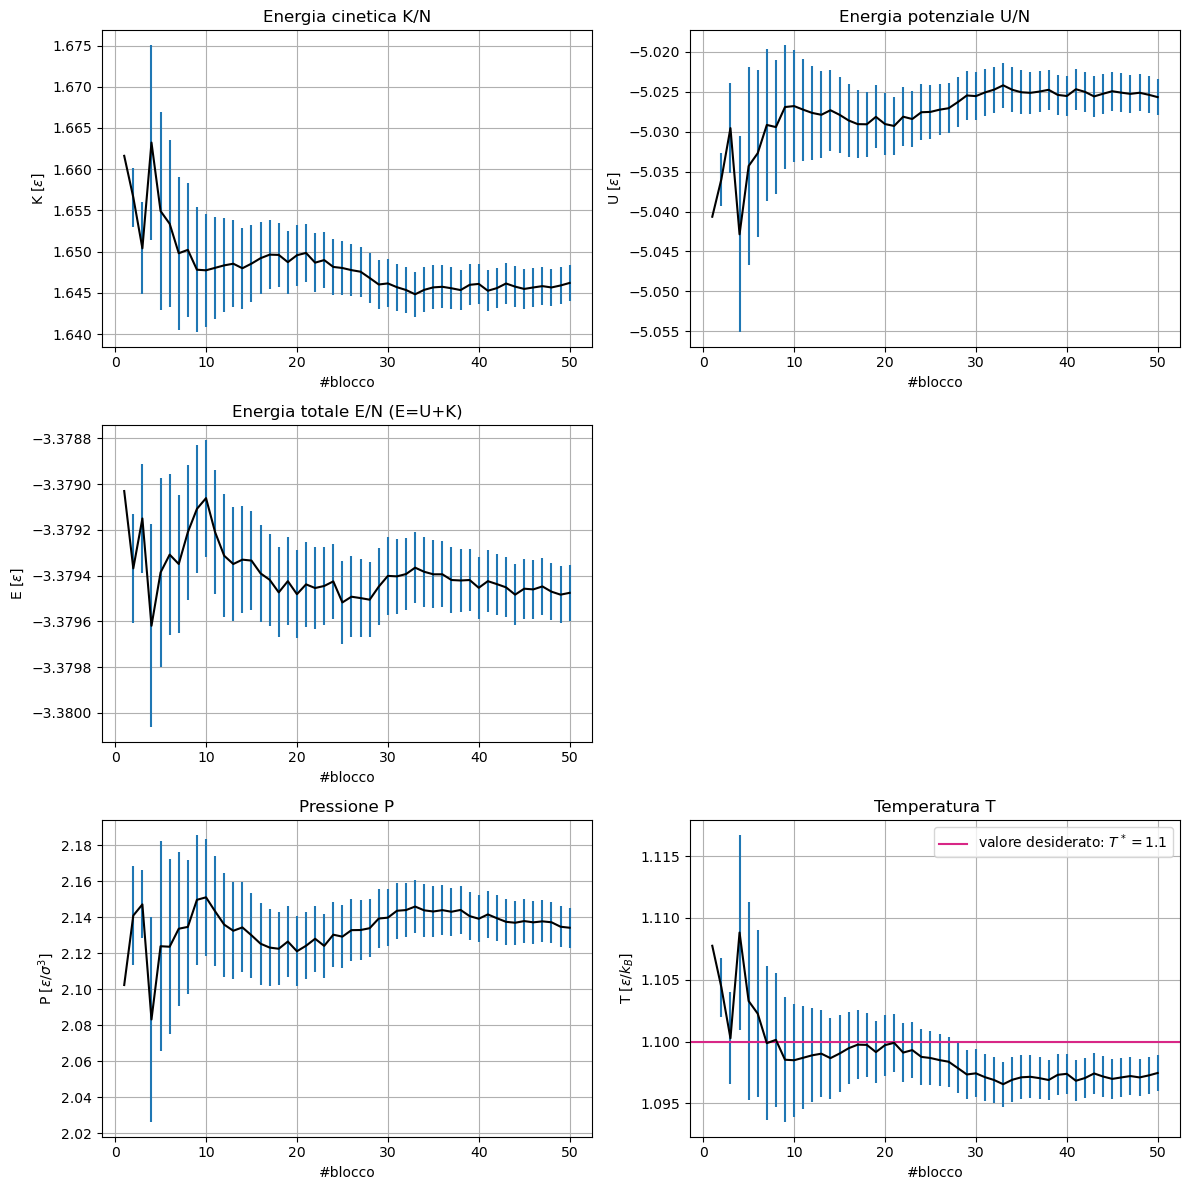

In [20]:
plotData("liquid", 1.1)

<h4> Stato gassoso </h4>

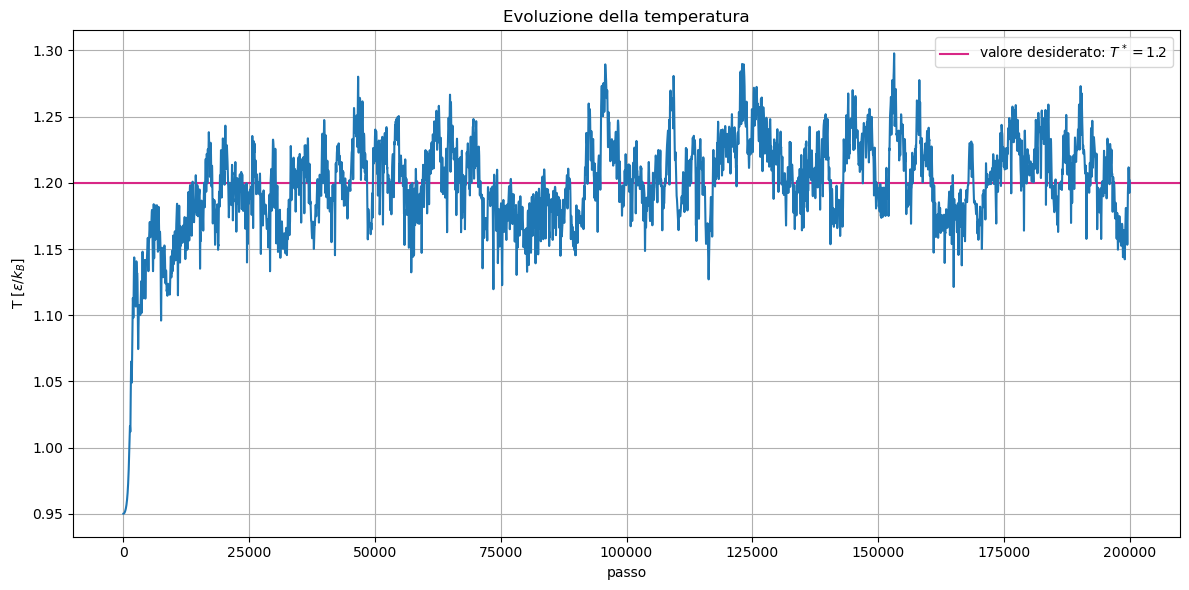

In [21]:
plotTherm("gas", 1.2)

Il sistema in fase gassosa impiega più tempo a termalizzare, per quanto detto in precedenza (partiamo da $T^*=0.95$). Dal grafico sembra che le oscillazioni della temperatura attorno al valore desiderato ($T^*=1.2$) inizino attorno ai $25000$ passi, ma non sembrano molto stabili fino circa dopo i $130000$. Come negli altri due casi, facciamo ripartire la simulazione dopo i $200000$ passi simulati per produrre questo grafico.  

Per studiare le grandezze d'interesse, le cui medie e incertezze progressive sono graficate in seguito, usiamo $50$ blocchi da $40000$ passi poiché le oscillazioni sono molto lente e ampie, decorate da molte oscillazioni veloci e meno ampie, poiché nel gas passa molto più tempo tra due interazioni successive.

Valori finali in unità ridotte:
<K/N> = 1.79437 +- 0.00221
<U/N> = -0.40246 +- 0.00221
<E/N> = 1.39191 +- 0.00001
<P> = 0.04933 +- 0.00006
<T> = 1.19624 +- 0.00147


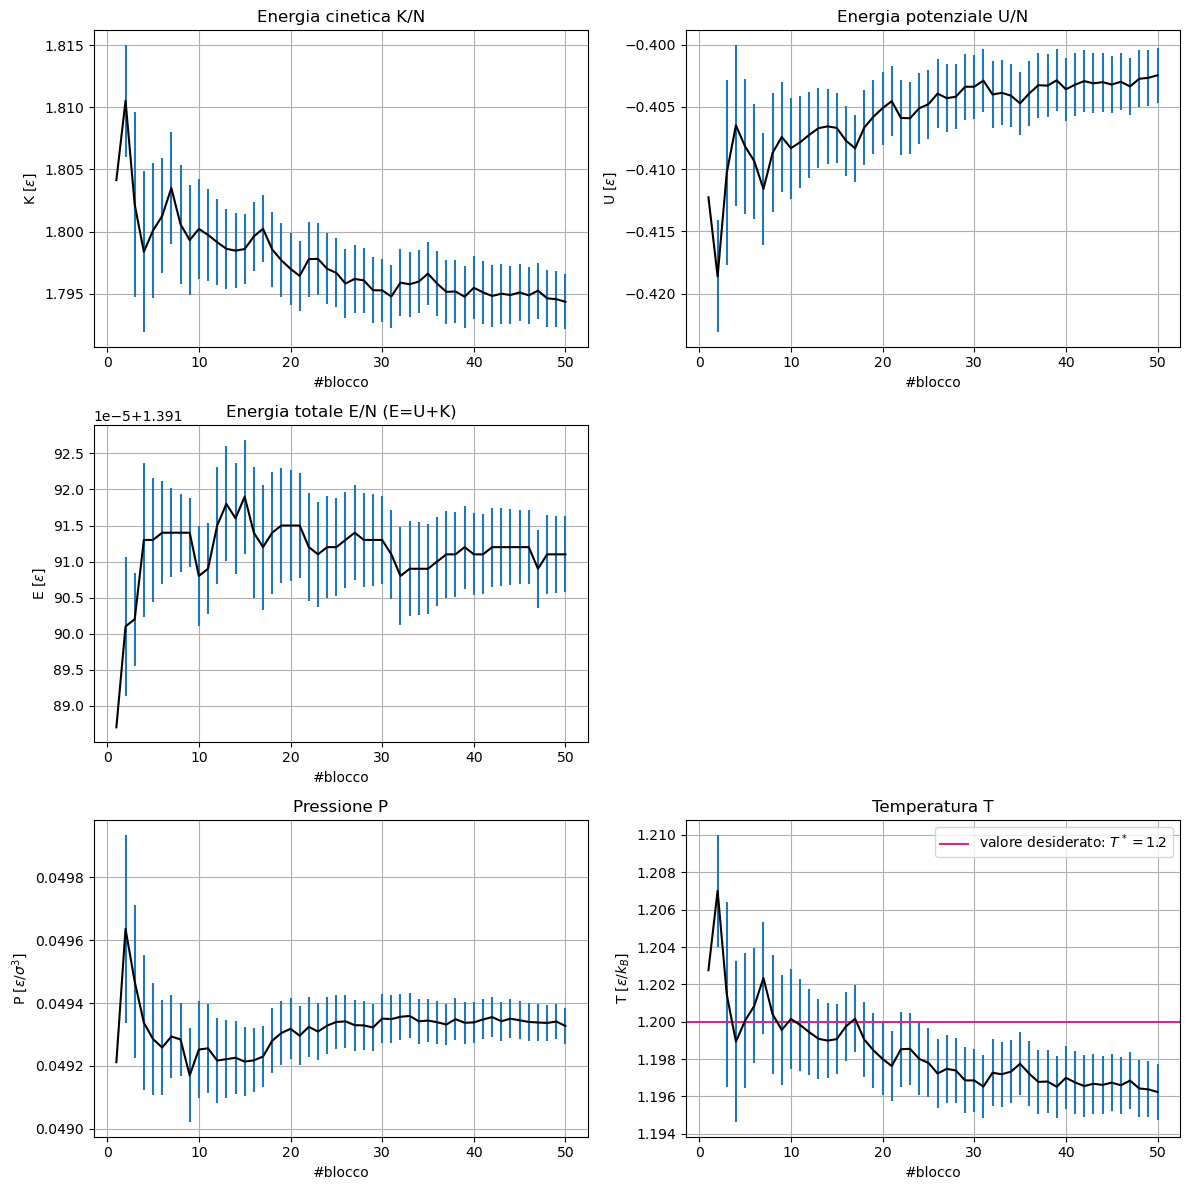

In [22]:
plotData("gas", 1.2)

<h4> Conclusioni </h4>

Per il sistema in fase solida e liquida, l'energia cinetica $K/N$, potenziale $U/N$ e totale $E/N$, la pressione $P$ e la temperatura $T$ convergono verso un valore medio finale, che, nel caso della temperatura, risulta compatibile con quello atteso. L'energia totale $E$ oscilla attorno a un certo valore con un periodo maggiore rispetto a $K$ e $U$: questo fatto era atteso, visto che la conservazione dell'energia non è trattata in modo esatto in questo algoritmo. Analizzando le incertezze associate a questi valori, concludiamo che la conservazione dell'energia è comunque rispettata con buonissima precisione, essendo l'incertezza su $E$ circa un ordine di grandezza inferiore rispetto a quelle su $K$ e $U$, che risultano essere simili.  
Per il sistema in fase gassosa, a causa della bassa densità, le particelle interagiscono poco, quindi l'energia è conservata con una precisione maggiore: l'incertezza su $E$ è due ordini di grandezza minore di quelle su $K$ e $U$, che anche in questo caso risultano simili tra loro.  

La temperatura è calcolata come $T=\frac{2}{3} \frac{K}{N}$, quindi l'andamento dei due grafici di $K$ e $T$ è identico.  

La pressione è calcolata come somma di due termini: il primo è $\rho^* T^*$, che è la legge dei gas perfetti ($P=\frac{N}{V}k_BT$); il secondo è un termine viriale che tiene conto dell'interazione tra le particelle. La legge dei gas perfetti vale per un gas rarefatto a particelle non interagenti.  
Per lo stato solido, dalla legge dei gas, otteniamo $P^*=0.88$, evidentemente errato poiché le interazioni tra le particelle non sono ovviamente trascurabili in un solido.  
Per lo stato liquido otteniamo $P^*=0.88$, che, anche avvicinandosi maggiormente in termini relativi al valore trovato della pressione, resta errato perché il termine viriale è ancora dominante.  
Per lo stato gassoso la legge dei gas perfetti dovrebbe essere una buona approssimazione, ma in questo caso il gas non è rarefatto, infatti troviamo una densità di $\rho = \rho^*/\sigma^3 \approx 10^{27}$ $1/m^3$, molto maggiore della densità dell'aria che è $\rho _{aria} \approx 2 \times 10^{25}$ $1/m^3$. Per la legge dei gas $P^*=0.06$, che per quanto errato è il più vicino in termini relativi al valore misurato.